<h1>目录<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#知识点" data-toc-modified-id="知识点-1">知识点</a></span></li><li><span><a href="#数据可视化" data-toc-modified-id="数据可视化-2">数据可视化</a></span><ul class="toc-item"><li><span><a href="#下载、解压数据集" data-toc-modified-id="下载、解压数据集-2.1">下载、解压数据集</a></span></li></ul></li><li><span><a href="#自编码器" data-toc-modified-id="自编码器-3">自编码器</a></span><ul class="toc-item"><li><span><a href="#子像素卷积（Sub-pixel-Convolution）" data-toc-modified-id="子像素卷积（Sub-pixel-Convolution）-3.1">子像素卷积（Sub-pixel Convolution）</a></span></li><li><span><a href="#下采样层（编码器）与上采样层（解码器）" data-toc-modified-id="下采样层（编码器）与上采样层（解码器）-3.2">下采样层（编码器）与上采样层（解码器）</a></span></li></ul></li><li><span><a href="#人脸互换基本架构" data-toc-modified-id="人脸互换基本架构-4">人脸互换基本架构</a></span><ul class="toc-item"><li><span><a href="#训练过程" data-toc-modified-id="训练过程-4.1">训练过程</a></span></li><li><span><a href="#运用过程" data-toc-modified-id="运用过程-4.2">运用过程</a></span></li><li><span><a href="#神经网络结构" data-toc-modified-id="神经网络结构-4.3">神经网络结构</a></span></li></ul></li><li><span><a href="#数据预处理" data-toc-modified-id="数据预处理-5">数据预处理</a></span><ul class="toc-item"><li><span><a href="#数据增强" data-toc-modified-id="数据增强-5.1">数据增强</a></span></li><li><span><a href="#图像裁剪与扭曲泛化" data-toc-modified-id="图像裁剪与扭曲泛化-5.2">图像裁剪与扭曲泛化</a></span></li><li><span><a href="#构建Batch数据集" data-toc-modified-id="构建Batch数据集-5.3">构建Batch数据集</a></span></li></ul></li><li><span><a href="#模型训练" data-toc-modified-id="模型训练-6">模型训练</a></span></li><li><span><a href="#模型运用" data-toc-modified-id="模型运用-7">模型运用</a></span></li><li><span><a href="#实验总结" data-toc-modified-id="实验总结-8">实验总结</a></span></li></ul></div>

## 知识点

- 数据可视化
- 数据增强
- 自编码器
- 上（下）采样
- 子像素卷积

## 数据可视化

### 下载、解压数据集

```python
!chcp 936
!aria2c --quiet https://labfile.oss.aliyuncs.com/courses/1460/data.zip
!unzip -o data.zip
%ls
```

In [1]:
# %% 获取文件路径
from os import scandir
from typing import List


def get_image_paths(directory: str) -> List[str]:
    """ 扫描特定目录，返回目录下所有文件 """
    return [
        x.path for x in scandir(directory)
        if x.name.endswith('.jpg') or x.name.endswith('.png')
    ]


images_A = get_image_paths('./trump/')
images_B = get_image_paths('./cage/')
print(f'川普有{len(images_A)}张图像，凯奇有{len(images_B)}张图像')

川普有376张图像，凯奇有318张图像


In [2]:
# %% 批量加载图像
import cv2
import numpy as np


def load_images(image_paths: List[str]) -> np.ndarray:
    """ 批量加载指定路径的图像 """
    iter_all_images = (cv2.imread(fn) for fn in image_paths)
    # 将生成器转换为 NumPy 数组
    for i, image in enumerate(iter_all_images):
        if i == 0:
            all_images = np.empty((len(image_paths), ) + image.shape,
                                  dtype=image.dtype)
        all_images[i] = image
    return all_images


A_images = load_images(images_A[:3])
B_images = load_images(images_B[:3])
print(A_images.shape, B_images.shape, sep='\n')

(3, 256, 256, 3)
(3, 256, 256, 3)


In [3]:
# %% 图像堆叠展示
from typing import Tuple


def get_transpose_axes(dim: int) -> Tuple[int]:
    """ 指导维度拼合方式 """
    if dim % 2 == 0:
        y_axes = list(range(1, dim - 1, 2))
        x_axes = list(range(0, dim - 1, 2))
    else:
        y_axes = list(range(0, dim - 1, 2))
        x_axes = list(range(1, dim - 1, 2))
    return y_axes, x_axes, [dim - 1]


def stack_images(images: np.ndarray) -> np.ndarray:
    """ 将多张图片堆叠展示 """
    images_shape = np.array(images.shape)
    new_axes = get_transpose_axes(len(images_shape))
    new_shape = [np.prod(images_shape[x]) for x in new_axes]
    return np.transpose(images,
                        axes=np.concatenate(new_axes)).reshape(new_shape)

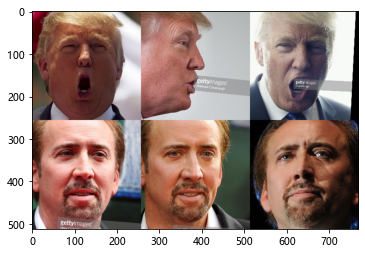

In [4]:
# %% 使用 Matplotlib 绘制图像
from matplotlib import pyplot as plt

plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 96
%matplotlib inline

figure = np.concatenate([A_images, B_images], axis=0)
figure = figure.reshape((2, 3) + figure.shape[1:])
figure = stack_images(figure)
plt.imshow(cv2.cvtColor(figure, cv2.COLOR_BGR2RGB))
plt.show()

## 自编码器

### 子像素卷积（Sub-pixel Convolution）

![模型示意图](./imgs/sub-pixel_conv.png)

&copy; 图片来源：[Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](https://arxiv.org/pdf/1609.05158.pdf)

- 一种巧妙的图像上采样算法，又叫**『像素洗牌』（Pixel Shuffle）**
- 2016年，由 **Wenzhe Shi** 等人提出
- 输入是维度为 $n \times n$ 大小的 $r$ 通道特征图，输出是维度为 $nr \times nr$ 大小的单通道特征图
- 在传统 CNN 卷积神经网络模型的尾层增加子像素卷积层

In [5]:
# 子像素卷积层，用于上采样
# PixelShuffler layer for Keras
from keras.utils import conv_utils
from keras.engine.topology import Layer
import keras.backend as K


class PixelShuffler(Layer):
    # 初始化 子像素卷积层，并在输入数据时，对数据进行标准化处理。
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(PixelShuffler, self).__init__(**kwargs)
        self.data_format = K.normalize_data_format(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')

    def call(self, inputs):
        # 根据得到输入层图层 batch_size，h ，w，c 的大小
        input_shape = K.int_shape(inputs)
        batch_size, h, w, c = input_shape
        if batch_size is None:
            batch_size = -1
        rh, rw = self.size

        # 计算转换后的图层大小与通道数
        oh, ow = h * rh, w * rw
        oc = c // (rh * rw)

        # 先将图层分开，并且将每一层装换到自己应该到维度
        # 最后再利用一次 reshape 函数（计算机会从外到里的一个个的将数据排下来），这就可以转成指定大小的图层了
        out = K.reshape(inputs, (batch_size, h, w, rh, rw, oc))
        out = K.permute_dimensions(out, (0, 1, 3, 2, 4, 5))
        out = K.reshape(out, (batch_size, oh, ow, oc))
        return out

    # compute_output_shape()函数用来输出这一层输出尺寸的大小
    # 尺寸是根据input_shape以及我们定义的output_shape计算的。
    def compute_output_shape(self, input_shape):
        height = input_shape[1] * self.size[0] if input_shape[
            1] is not None else None
        width = input_shape[2] * self.size[1] if input_shape[
            2] is not None else None
        channels = input_shape[3] // self.size[0] // self.size[1]

        return (input_shape[0], height, width, channels)

    # 设置配置文件
    def get_config(self):
        config = {'size': self.size, 'data_format': self.data_format}
        base_config = super(PixelShuffler, self).get_config()

        return dict(list(base_config.items()) + list(config.items()))

Using TensorFlow backend.


### 下采样层（编码器）与上采样层（解码器）

- 每个下采样层包括：
  - 一个 Conv2D 卷积层：用于缩小图层信息、提取图层特征
  - 一个 LeakyReLU 激活层
- 每个上采样层包括：
  - 一个 Conv2D 卷积层：用于扩大图层通道数量
  - 一个 LeakyReLU 激活层
  - 一个 PixelShuffle 洗牌层

In [6]:
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D


# 下采样层,filters 为输出图层的通道数
# n * n * c -> 0.5n * 0.5n * filters
def conv(filters):
    def block(x):
        # 每一层由一个使图层大小减小一半的卷积层和一个 LeakyReLU 激活函数层构成。
        x = Conv2D(filters, kernel_size=5, strides=2, padding='same')(x)
        x = LeakyReLU(0.1)(x)
        return x

    return block


# 上采样层，扩大图层大小
# 图层的形状变化如下：
# n*n*c -> n * n * 4filters -> 2n * 2n * filters
def upscale(filters):
    # 每一层由一个扩大通道层的卷积，一个激活函数和一个像素洗牌层
    def block(x):
        # 将通道数扩大为原来的四倍。为了下一步能够通过像素洗牌 使原来的图层扩大两倍
        x = Conv2D(filters * 4, kernel_size=3, padding='same')(x)
        x = LeakyReLU(0.1)(x)
        x = PixelShuffler()(x)
        return x

    return block

In [7]:
# %% 编解码测试
import tensorflow as tf

x1 = tf.convert_to_tensor(A_images, dtype=tf.float32)
x2 = conv(126)(x1)
x3 = upscale(3)(x2)
print(f'下采样：输入图像大小 {x1.shape} ，目标通道数量 126 ，输出图像大小 {x2.shape}')
print(f'上采样：输入图像大小 {x2.shape} ，目标通道数量 3 ，输出图像大小 {x3.shape}')

下采样：输入图像大小 (3, 256, 256, 3) ，目标通道数量 126 ，输出图像大小 (3, 128, 128, 126)
上采样：输入图像大小 (3, 128, 128, 126) ，目标通道数量 3 ，输出图像大小 (3, 256, 256, 3)


## 人脸互换基本架构

1个编码器和2个解码器。

### 训练过程

![训练过程](./training_steps.svg)

使用相同编码器进行特征提取，再将特征放到各自的解码器中还原。计算原始图与还原图的损失，反向传播进行参数优化。

自编码模型也是一种自监督学习模型，训练集同时作为输入和输出。

### 运用过程

将原始图片传入不同的解码器，实现面部替换。

![运用过程](./imgs/evaluate_steps.svg)

### 神经网络结构

![网络结构](./imgs/network_structure.svg)

- 中间部分为编码器，4层下采样、2层稠密全连接、1层上采样。下采样用于提取图像特征，全连接用于打乱特征空间结构，上采样提升图像大小。
- 上下部分为解码器，3层上采样、1层下采样。上采样扩大图像获得原图大小，下采样缩小通道数量为RGB全彩图。

In [8]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape

# 原始图像大小
IMAGE_SHAPE = (64, 64, 3)
# 全连接层神经元数量
ENCODER_DIM = 1024


def Encoder():
    """ 编码器 """
    input_ = Input(shape=IMAGE_SHAPE)
    # 卷积提升至 1024 通道
    x = conv(128)(input_)
    x = conv(256)(x)
    x = conv(512)(x)
    x = conv(ENCODER_DIM)(x)
    # 像素值展开
    x = Flatten()(x)
    # 全连接
    x = Dense(ENCODER_DIM)(x)
    x = Dense(4**2 * ENCODER_DIM)(x)
    # 还原为图像
    x = Reshape((4, 4, ENCODER_DIM))(x)
    # 上采样放大图像并压缩通道数
    x = upscale(512)(x)
    return Model(input_, x)


def Decoder():
    """ 解码器 """
    input_ = Input(shape=(8, 8, 512))
    # 上采样
    x = upscale(256)(input_)
    x = upscale(128)(x)
    x = upscale(64)(x)
    x = Conv2D(3, kernel_size=5, padding='same', activation='sigmoid')(x)
    return Model(input_, x)

In [9]:
# %% 构建完整自监督模型
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=5e-5, beta_1=0.5, beta_2=0.999)
encoder = Encoder()
decoder_A = Decoder()
decoder_B = Decoder()

x = Input(shape=IMAGE_SHAPE)
model_A = Model(x, decoder_A(encoder(x)))
model_B = Model(x, decoder_B(encoder(x)))
model_A.compile(optimizer=optimizer, loss='mean_absolute_error')
model_B.compile(optimizer=optimizer, loss='mean_absolute_error')
model_A, model_B

(<keras.engine.training.Model at 0x14c88779848>,
 <keras.engine.training.Model at 0x14c88774f88>)

## 数据预处理

![数据预处理](./imgs/data_preprocessing.svg)

### 数据增强

- 不消耗额外成本获得更多数据样本
- 旋转、平移、缩放、裁剪，将一张原始图像变换为多张图像

In [10]:
def random_transform(image):
    """ 随机图像变换 """
    h, w = image.shape[:2]
    rotation = np.random.uniform(-10, 10)
    scale = np.random.uniform(0.95, 1.05)
    tx, ty = np.random.uniform(-0.05, 0.05) * w, np.random.uniform(
        -0.05, 0.05) * h
    # 获取变换矩阵
    matrix = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)
    matrix[:, 2] += (tx, ty)
    result = cv2.warpAffine(image,
                            matrix, (w, h),
                            borderMode=cv2.BORDER_REPLICATE)
    # 40%图像翻转率
    if np.random.random() < 0.4:
        result = result[:, ::-1]
    return result

变换前图像大小：(256, 256, 3)，变换后图像大小：(256, 256, 3)


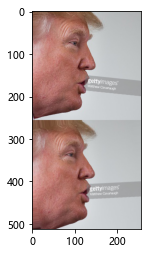

In [11]:
old_image = A_images[1]
transform_image = random_transform(old_image)
print(f'变换前图像大小：{old_image.shape}，变换后图像大小：{transform_image.shape}')
# 用 Matplotlib 展示图像
figure = np.concatenate([old_image, transform_image], axis=0)
figure = stack_images(figure)
plt.imshow(cv2.cvtColor(figure, cv2.COLOR_BGR2RGB))

### 图像裁剪与扭曲泛化

- 将面部区域裁剪出来，只保留面部特征，将 $256 \times 256$ 降低到 $64 \times 64$ 
- 提升训练速度和准确性
- 使用像素扭曲（将像素打散到不同位置）提高泛化性

In [12]:
# License (Modified BSD)
# umeyama function from scikit-image/skimage/transform/_geometric.py
def umeyama(src, dst, estimate_scale):
    """Estimate N-D similarity transformation with or without scaling.
    Parameters
    ----------
    src : (M, N) array
        Source coordinates.
    dst : (M, N) array
        Destination coordinates.
    estimate_scale : bool
        Whether to estimate scaling factor.
    Returns
    -------
    T : (N + 1, N + 1)
        The homogeneous similarity transformation matrix. The matrix contains
        NaN values only if the problem is not well-conditioned.
    References
    ----------
    .. [1] "Least-squares estimation of transformation parameters between two
            point patterns", Shinji Umeyama, PAMI 1991, DOI: 10.1109/34.88573
    """

    num = src.shape[0]
    dim = src.shape[1]

    # Compute mean of src and dst.
    src_mean = src.mean(axis=0)
    dst_mean = dst.mean(axis=0)

    # Subtract mean from src and dst.
    src_demean = src - src_mean
    dst_demean = dst - dst_mean

    # Eq. (38). 下面的Eq 都分别对应着论文中的公式
    A = np.dot(dst_demean.T, src_demean) / num

    # Eq. (39).
    d = np.ones((dim, ), dtype=np.double)
    if np.linalg.det(A) < 0:
        d[dim - 1] = -1

    T = np.eye(dim + 1, dtype=np.double)

    U, S, V = np.linalg.svd(A)

    # Eq. (40) and (43).
    rank = np.linalg.matrix_rank(A)
    if rank == 0:
        return np.nan * T
    elif rank == dim - 1:
        if np.linalg.det(U) * np.linalg.det(V) > 0:
            T[:dim, :dim] = np.dot(U, V)
        else:
            s = d[dim - 1]
            d[dim - 1] = -1
            T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V))
            d[dim - 1] = s
    else:
        T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V.T))

    if estimate_scale:
        # Eq. (41) and (42).
        scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
    else:
        scale = 1.0

    T[:dim, dim] = dst_mean - scale * np.dot(T[:dim, :dim], src_mean.T)
    T[:dim, :dim] *= scale

    return T

In [13]:
def random_warp(image):
    """ 使用裁剪和随机卷曲生成训练集，使用点云匹配生成标签集 """
    # 强制要求图像大小
    assert image.shape == (256, 256, 3)
    range_ = np.linspace(128 - 80, 128 + 80, 5)
    # 数组广播形成矩阵
    mapx = np.broadcast_to(range_, (5, 5))
    mapy = mapx.T
    # 加偏
    mapx = mapx + np.random.normal(scale=5, size=(5, 5))
    mapy = mapy + np.random.normal(scale=5, size=(5, 5))
    # 缩放并裁剪
    interp_mapx = cv2.resize(mapx, (80, 80))[8:72, 8:72].astype('float32')
    interp_mapy = cv2.resize(mapy, (80, 80))[8:72, 8:72].astype('float32')
    # 执行图像操作
    wraped_image = cv2.remap(image, interp_mapx, interp_mapy, cv2.INTER_LINEAR)

    ### 制作标签集 ###
    src_point = np.stack([mapx.ravel(), mapy.ravel()], axis=1)
    dst_point = np.mgrid[0:65:16, 0:65:16].T.reshape(-1, 2)
    matrix = umeyama(src_point, dst_point, True)[:2]
    target_image = cv2.warpAffine(image, matrix, (64, 64))

    return wraped_image, target_image

In [14]:
wraped_image, target_image = random_warp(transform_image)
print(f'变换前图像大小：{wraped_image.shape}，变换后图像大小：{target_image.shape}')

变换前图像大小：(64, 64, 3)，变换后图像大小：(64, 64, 3)


### 构建Batch数据集

- 按照`batch_size`对数据集分批处理，提升收敛速度

In [15]:
def get_training_data(images, batch_size):
    # 分批过程中将图片顺序打散
    indices = np.random.randint(len(images), size=batch_size)
    for i, index in enumerate(indices):
        image = images[index]
        # 图像预处理
        image = random_transform(image)
        warped_image, target_image = random_warp(image)
        # 分批次
        if i == 0:
            wraped_images = np.empty((batch_size, ) + wraped_image.shape,
                                     wraped_image.dtype)
            target_images = np.empty((batch_size, ) + target_image.shape,
                                     target_image.dtype)
        wraped_images[i] = wraped_image
        target_images[i] = target_image
    return wraped_images, target_images

In [16]:
# 加载图像并归一化
images_A = load_images(images_A) / 255.0
images_B = load_images(images_B) / 255.0
images_A += images_B.mean(axis=(0, 1, 2)) - images_A.mean(axis=(0, 1, 2))
# 分批处理，20张/批次
wraped_A, target_A = get_training_data(images_A, 20)
wraped_A.shape, target_A.shape

((20, 64, 64, 3), (20, 64, 64, 3))

## 模型训练

In [17]:
def save_model_weights():
    encoder.save_weights("encoder.h5")
    decoder_A.save_weights("decoder_A.h5")
    decoder_B.save_weights("decoder_A.h5")
    print('模型权重信息已保存！')

In [18]:
# 执行训练
epochs = 10
for epoch in range(epochs):
    print(f'第{epoch}代，开始训练...')
    batch_size = 32
    # 获取单批次的数据集
    wraped_A, target_A = get_training_data(images_A, batch_size)
    wraped_B, target_B = get_training_data(images_B, batch_size)
    loss_A = model_A.train_on_batch(wraped_A, target_A)
    loss_B = model_B.train_on_batch(wraped_B, target_B)
    print('模型A损失值{:.4f}，模型B损失值：{:.4f}'.format(loss_A, loss_B))
    pass

# 保存模型
save_model_weights()

第0代，开始训练...
模型A损失值0.1903，模型B损失值：0.1902
第1代，开始训练...
模型A损失值0.1858，模型B损失值：0.1797
第2代，开始训练...
模型A损失值0.1854，模型B损失值：0.1842
第3代，开始训练...
模型A损失值0.1797，模型B损失值：0.1671
第4代，开始训练...
模型A损失值0.1684，模型B损失值：0.1664
第5代，开始训练...
模型A损失值0.1628，模型B损失值：0.1576
第6代，开始训练...
模型A损失值0.1783，模型B损失值：0.1611
第7代，开始训练...
模型A损失值0.1808，模型B损失值：0.1503
第8代，开始训练...
模型A损失值0.1600，模型B损失值：0.1538
第9代，开始训练...
模型A损失值0.1667，模型B损失值：0.1485
模型权重信息已保存！


## 模型运用

```bash
# 下载
wget -nc "https://labfile.oss.aliyuncs.com/courses/1460/models_weights.zip"
# 解压
unzip -o "models_weights.zip"
```

In [19]:
# %% 模型加载
encoder.load_weights('./encoder.h5')
decoder_A.load_weights('./decoder_A.h5')
decoder_B.load_weights('./decoder_B.h5')

In [20]:
# %% 图像预处理
images_A = get_image_paths('./trump/')
images_B = get_image_paths('./cage/')
# 归一化
images_A = load_images(images_A) / 255.0
images_B = load_images(images_B) / 255.0
# 分批次
images_A += images_B.mean(axis=(0, 1, 2)) - images_A.mean(axis=(0, 1, 2))
batch_size = 64
wraped_A, target_A = get_training_data(images_A, batch_size)
wraped_B, target_B = get_training_data(images_B, batch_size)

In [21]:
# %% 执行换脸操作
test_A = target_A[:3]
test_B = target_B[:3]
# 拼接图像
figure_A = np.stack(
    [test_A, model_A.predict(test_A),
     model_B.predict(test_A)], axis=1)
figure_B = np.stack(
    [test_B, model_B.predict(test_B),
     model_A.predict(test_B)], axis=1)

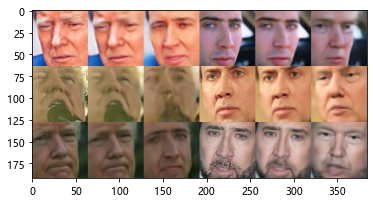

In [22]:
# %% 图像绘制
figure = np.concatenate([figure_A, figure_B], axis=0)
figure = figure.reshape((2, 3) + figure.shape[1:])
figure = stack_images(figure)
# 反归一化
figure = np.clip(figure * 255, 0, 255).astype('uint8')
# 展示图像
plt.imshow(cv2.cvtColor(figure, cv2.COLOR_BGR2RGB))
plt.show()

## 实验总结

- 数据可视化（Matplotlib 绘制图片内容）
- Keras 自编码模型构建
- 图像上采样和下采样技术
- 计算机视觉数据增强算法